# Import libraries


In [1]:
#import libraries

# SUPPRESS WARININGs!!
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

SEED = 42

PATH = "/content/drive/MyDrive/PW02-Neuroengineering/"


from google.colab import drive
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from collections import Counter
import math
import scipy
from scipy.signal import butter, filtfilt, iirnotch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import gc
import torch.nn.functional as F

import time

from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score,  roc_curve, classification_report
import matplotlib.pyplot as plt
from google.colab import drive



In [2]:
#drive.mount("/content/drive")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Exploration and Data Analysis

In [3]:
#prepare functions for filtering

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=1, highcut=40, fs=500, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def notch_filter(data, freq=50, fs=500, quality_factor=30):      #  remove noise (50hz)
    b, a = iirnotch(freq / (fs / 2), quality_factor)
    return filtfilt(b, a, data)

In [4]:
# only on kaggle

PATH = "/kaggle/input/test-ecg-pw02-1/drive-download-20251124T104021Z-1-001/"

In [5]:
#import the data and filter the signals

ECG_folder = f"{PATH}1_batch_extracted"
ECG_folder_2batch = f"{PATH}2_batch_extracted"


tabular_data = pd.read_excel(f"{PATH}VALETUDO_database_1st_batch_en_all_info.xlsx")
tabular_data_2batch = pd.read_excel(f"{PATH}VALETUDO_database_2nd_batch_en_all_info.xlsx")

# --- Load and filter both batches ---
ECGs_1 = [f for f in os.listdir(ECG_folder) if f.endswith(".mat")]
ECGs_2 = [f for f in os.listdir(ECG_folder_2batch) if f.endswith(".mat")]

def extract_patient_id(filename):
    return int(filename.split(".")[0])

ECGs_1.sort(key=extract_patient_id)
ECGs_2.sort(key=extract_patient_id)

signals_1 = np.empty((len(ECGs_1), 5000, 12))    # empty 3d array   5000 --> time lenght / 12 --> leads
signals_2 = np.empty((len(ECGs_2), 5000, 12))


In [6]:

for index, ecg_path in enumerate(ECGs_1):
    filepath = os.path.join(ECG_folder, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])    #signal centered in 0
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])  # filter
        ecg[:, i] = notch_filter(ecg[:, i])           #filter noise
    signals_1[index, :, :] = ecg

# --- same ---

for index, ecg_path in enumerate(ECGs_2):
    filepath = os.path.join(ECG_folder_2batch, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_2[index, :, :] = ecg


In [7]:
# --- Concatenate signals and tabular data ---
signals = np.concatenate([signals_1, signals_2], axis=0)
tabular_data = pd.concat([
    tabular_data.sort_values(by="ECG_patient_id").reset_index(drop=True),
    tabular_data_2batch.sort_values(by="ECG_patient_id").reset_index(drop=True)
], ignore_index=True)

print("Combined signals shape:", signals.shape)
print("Combined tabular shape:", tabular_data.shape)

Combined signals shape: (526, 5000, 12)
Combined tabular shape: (526, 18)


In [8]:
print(f"nb pos: {np.sum(tabular_data['sport_ability']==1)}")
print(f"% pos: {np.sum(tabular_data['sport_ability']==1)/len(tabular_data['sport_ability'])*100:.2f}%")

nb pos: 360
% pos: 68.44%


dataset ~ sbilanciato, circa 70% classe 1

In [9]:
tabular_data.head(5)

,ECG_patient_id,age_at_exam,sex,weight,height,trainning_load,sport_classification,sport_ability,AV block,ST abnormality,Complete BBB,Prolonged QTc,Uncontrolled hypertension,Supraventricular arrhythmias,Ventricular arrhythmias,Baseline ECG abnormalities,Valvular heart diseases,Symptomatic patients
0,3,20.095825,0,60.0,166.0,2.0,1,0,0,0,0,0,0,0,1,0,0,0
1,4,51.646817,0,84.0,180.0,2.0,1,0,0,1,0,0,1,0,0,0,0,0
2,5,40.936345,0,104.0,180.0,1.0,1,0,0,0,0,0,0,0,1,0,0,0
3,6,14.201232,0,80.0,174.0,2.0,1,1,0,0,0,0,0,0,0,0,0,0
4,7,16.607803,1,47.0,148.0,2.0,1,0,0,1,0,0,0,0,0,1,0,0


In [10]:
tabular_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ECG_patient_id                526 non-null    int64  
 1   age_at_exam                   526 non-null    float64
 2   sex                           526 non-null    int64  
 3   weight                        452 non-null    float64
 4   height                        452 non-null    float64
 5   trainning_load                525 non-null    float64
 6   sport_classification          526 non-null    int64  
 7   sport_ability                 526 non-null    int64  
 8   AV block                      526 non-null    int64  
 9   ST abnormality                526 non-null    int64  
 10  Complete BBB                  526 non-null    int64  
 11  Prolonged QTc                 526 non-null    int64  
 12  Uncontrolled hypertension     526 non-null    int64  
 13  Supra

do not need encoding, everything already numerical

In [11]:
#tabular_data.isnull().sum()

In [12]:
tabular_data = tabular_data.dropna(axis=1)
tabular_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ECG_patient_id                526 non-null    int64  
 1   age_at_exam                   526 non-null    float64
 2   sex                           526 non-null    int64  
 3   sport_classification          526 non-null    int64  
 4   sport_ability                 526 non-null    int64  
 5   AV block                      526 non-null    int64  
 6   ST abnormality                526 non-null    int64  
 7   Complete BBB                  526 non-null    int64  
 8   Prolonged QTc                 526 non-null    int64  
 9   Uncontrolled hypertension     526 non-null    int64  
 10  Supraventricular arrhythmias  526 non-null    int64  
 11  Ventricular arrhythmias       526 non-null    int64  
 12  Baseline ECG abnormalities    526 non-null    int64  
 13  Valvu

rn dropped weight height training_load columns

future test we can drop the rows (at least training load w 1 NA)



# Data Preprocessing

In [13]:

TARGET_COL = 'sport_ability'
ID_COL = 'ECG_patient_id'

patient_labels = tabular_data.groupby(ID_COL)[TARGET_COL].first()
unique_patient_ids = patient_labels.index.values
unique_patient_targets = patient_labels.values

# 80% patient train
train_ids, temp_ids, train_targets, temp_targets = train_test_split(
    unique_patient_ids,
    unique_patient_targets,
    test_size=0.2,
    stratify=unique_patient_targets,
    random_state=SEED
)

# 10% patient val, 10% test
val_ids, test_ids, val_targets, test_targets = train_test_split(
    temp_ids,
    temp_targets,
    test_size=0.5,
    stratify=temp_targets,
    random_state=SEED
)

# mask
train_mask = tabular_data[ID_COL].isin(train_ids)
val_mask   = tabular_data[ID_COL].isin(val_ids)
test_mask  = tabular_data[ID_COL].isin(test_ids)

# --- TRAINING SET ---
X_sig_train = signals[train_mask]
X_tab_train = tabular_data[train_mask].drop(columns=[TARGET_COL])
y_train     = tabular_data[train_mask][TARGET_COL]

# --- VALIDATION SET ---
X_sig_val   = signals[val_mask]
X_tab_val   = tabular_data[val_mask].drop(columns=[TARGET_COL])
y_val       = tabular_data[val_mask][TARGET_COL]

# --- TEST SET ---
X_sig_test  = signals[test_mask]
X_tab_test  = tabular_data[test_mask].drop(columns=[TARGET_COL])
y_test      = tabular_data[test_mask][TARGET_COL]


# --- CHECK ---
print(f"Patients: {len(unique_patient_ids)}")
print(f"Train IDs: {len(train_ids)}, Val IDs: {len(val_ids)}, Test IDs: {len(test_ids)}")
print("-" * 30)
print(f'Training set:   {X_sig_train.shape} {X_tab_train.shape} -> {y_train.shape}')
print(f'Validation set: {X_sig_val.shape}   {X_tab_val.shape}   -> {y_val.shape}')
print(f'Test set:       {X_sig_test.shape}  {X_tab_test.shape}  -> {y_test.shape}')

assert set(tabular_data[train_mask][ID_COL]) & set(tabular_data[val_mask][ID_COL]) == set()
print("Integrity OK --> no patient split")

Patients: 526
Train IDs: 420, Val IDs: 53, Test IDs: 53
------------------------------
Training set:   (420, 5000, 12) (420, 14) -> (420,)
Validation set: (53, 5000, 12)   (53, 14)   -> (53,)
Test set:       (53, 5000, 12)  (53, 14)  -> (53,)
Integrity OK --> no patient split


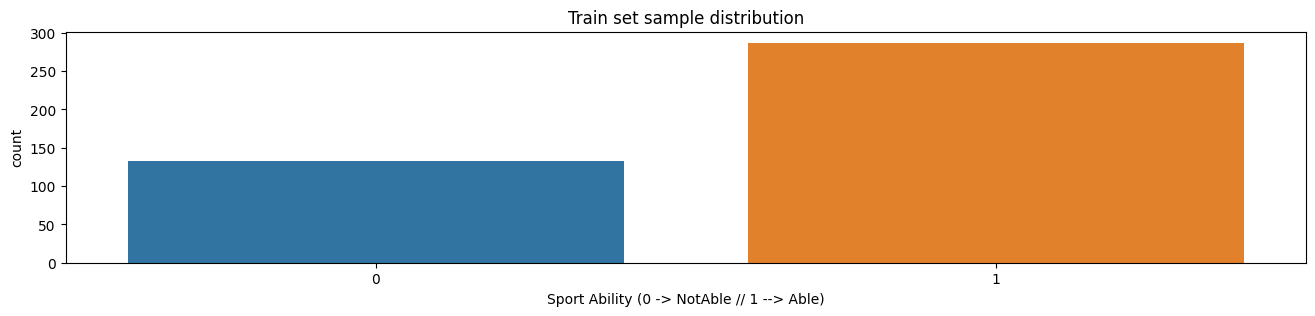

In [14]:
plt.figure(figsize=(16, 3))

sns.countplot(x=y_train, palette='tab10')

plt.title("Train set sample distribution")
plt.xlabel("Sport Ability (0 -> NotAble // 1 --> Able)")
plt.show()

## Normalization


In [15]:
COLS_TO_SCALE = ['age_at_exam']  # only normalize this column for tab data. add weight height if we dont delete them

# normalize tabular data

scaler_tab = MinMaxScaler()
scaler_tab.fit(X_tab_train[COLS_TO_SCALE])

X_tab_train.loc[:, COLS_TO_SCALE] = scaler_tab.transform(X_tab_train[COLS_TO_SCALE])
X_tab_val.loc[:, COLS_TO_SCALE]   = scaler_tab.transform(X_tab_val[COLS_TO_SCALE])
X_tab_test.loc[:, COLS_TO_SCALE]  = scaler_tab.transform(X_tab_test[COLS_TO_SCALE])

In [16]:
# func to normalize signals z-score
def normalize_instance_wise(signals):

    mean = np.mean(signals, axis=1, keepdims=True)
    std = np.std(signals, axis=1, keepdims=True)

    epsilon = 1e-8

    return (signals - mean) / (std + epsilon)

In [17]:
X_sig_train_norm = normalize_instance_wise(X_sig_train)
X_sig_val_norm   = normalize_instance_wise(X_sig_val)
X_sig_test_norm  = normalize_instance_wise(X_sig_test)


### Data Augmentation

In [18]:
WINDOW_SIZE = 2500
STRIDE = 250       # --> duplicate data. use 625 for 4x

BATCH_SIZE = 32
JITTER_STRENGTH = 0.15

CHANNEL_MASK = 0.4

In [19]:
def build_sequences_numpy(signals, tabular, labels, window=2500, stride=1250):

    X_sig_seq = []
    X_tab_seq = []
    y_seq = []

    num_patients = signals.shape[0]
    signal_len = signals.shape[1]

    for i in range(num_patients):

        curr_sig = signals[i]
        curr_tab = tabular.iloc[i].values
        curr_label = labels.iloc[i] if hasattr(labels, 'iloc') else labels[i]

        idx = 0
        while idx + window <= signal_len:
            segment = curr_sig[idx : idx + window, :]

            X_sig_seq.append(segment)
            X_tab_seq.append(curr_tab)
            y_seq.append(curr_label)

            idx += stride

    return np.array(X_sig_seq), np.array(X_tab_seq), np.array(y_seq)

In [20]:

# training
X_sig_train_seq, X_tab_train_seq, y_train_seq = build_sequences_numpy(
    X_sig_train_norm, X_tab_train, y_train, window=WINDOW_SIZE, stride=1250
)

# Validation e Test (we dont augment data here)
X_sig_val_seq, X_tab_val_seq, y_val_seq = build_sequences_numpy(
    X_sig_val_norm, X_tab_val, y_val, window=WINDOW_SIZE, stride=WINDOW_SIZE
)

X_sig_test_seq, X_tab_test_seq, y_test_seq = build_sequences_numpy(
    X_sig_test_norm, X_tab_test, y_test, window=WINDOW_SIZE, stride=WINDOW_SIZE
)

# --- check ---
print(f"Original Train Patients: {X_sig_train_norm.shape[0]}")
print(f"Augmented Train Segments: {X_sig_train_seq.shape}")
print(f"Augmented Tabular Shape: {X_tab_train_seq.shape}")
print(f"Augmented Labels Shape: {y_train_seq.shape}")

Original Train Patients: 420
Augmented Train Segments: (1260, 2500, 12)
Augmented Tabular Shape: (1260, 14)
Augmented Labels Shape: (1260,)


In [21]:
class ECGThreeBranchDataset(Dataset):
    def __init__(self, signals, tabular, labels=None, is_train=False, JITTER_STRENGTH=0.05, CHANNEL_MASK=0.3):
        """
        signals: (N, 2500, 12) -> splitted in (N, 6, 2500) and (N, 6, 2500)  --> to get 6 leads/6 leads
        """
        self.signals = torch.tensor(signals, dtype=torch.float32).permute(0, 2, 1)
        self.tabular = torch.tensor(tabular, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None

        self.is_train = is_train
        self.jitter_strength = JITTER_STRENGTH
        self.channel_mask_prob = CHANNEL_MASK

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        full_sig = self.signals[idx].clone()

        if self.is_train:

            shift = torch.randint(low=-250, high=250, size=(1,)).item()   #time shifting
            full_sig = torch.roll(full_sig, shifts=shift, dims=1)

            if self.jitter_strength > 0:          # jitter -> put JITTER_STRENGHT = 0 to pass w/
                noise = torch.randn_like(full_sig) * self.jitter_strength
                full_sig = full_sig + noise

            # Channel Masking   --> turn a signal to 0 to prevent model laziness
            if self.channel_mask_prob > 0 and torch.rand(1) < self.channel_mask_prob:
                mask_idx = torch.randint(0, 12, (1,)).item()
                full_sig[mask_idx, :] = 0 
                
        
        # we get 3 dataset --> model needs 3 branch
        # branch 1: Limb Leads (first 6: I, II, III, aVR, aVL, aVF)
        limb_sig = full_sig[:6, :]      # Shape: (6, 2500)

        # Branch 2: Precordial Leads (last  6: V1-V6)
        prec_sig = full_sig[6:, :]      # Shape: (6, 2500)

        # Branch 3: Tabular
        tab_data = self.tabular[idx]

        if self.labels is not None:
            return limb_sig, prec_sig, tab_data, self.labels[idx]
        else:
            return limb_sig, prec_sig, tab_data

In [22]:
def make_loader(ds, batch_size, shuffle, drop_last=False):

    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=2,
    )

In [23]:
# create train dataset
train_ds = ECGThreeBranchDataset(
    X_sig_train_seq, 
    X_tab_train_seq, 
    y_train_seq, 
    is_train=True,
    JITTER_STRENGTH = JITTER_STRENGTH,   
    CHANNEL_MASK = CHANNEL_MASK)
# create val test dataset
val_ds   = ECGThreeBranchDataset(X_sig_val_seq, X_tab_val_seq, y_val_seq, is_train=False)
test_ds  = ECGThreeBranchDataset(X_sig_test_seq, X_tab_test_seq, y_test_seq, is_train=False)

# create loaders
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = make_loader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = make_loader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

print("Dataloaders created!")

Dataloaders created!


In [24]:
# --- SANITY CHECK ---

for limb_batch, prec_batch, tab_batch, label_batch in train_loader:

    print("--- Batch Shapes ---")
    print(f"Limb Leads Batch:        {limb_batch.shape}  -> (Batch, 6, Time)")
    print(f"Precordial Leads Batch:  {prec_batch.shape}  -> (Batch, 6, Time)")
    print(f"Tabular Batch:           {tab_batch.shape}   -> (Batch, Features)")
    print(f"Labels Batch:            {label_batch.shape} -> (Batch)")

    assert limb_batch.shape[1] == 6, "Error: Limb Leads should be 6"
    assert prec_batch.shape[1] == 6, "Error: Precordial Leads should be 6"
    assert limb_batch.shape[2] == prec_batch.shape[2], "Error time"

    break

# --- Network Configuration Parameters ---
# Recuperiamo le dimensioni dai dati numpy originali (prima del dataset)
# Nota: X_sig_train_seq è (N_samples, 2500, 12)
n_timesteps = X_sig_train_seq.shape[1] # 2500
total_channels = X_sig_train_seq.shape[2] # 12
n_tab_feats = X_tab_train_seq.shape[1]
n_classes   = len(np.unique(y_train_seq))

print("\n\n--- Network Configuration ---")
print(f"Total Input Channels: {total_channels} (Split into 6 Limb + 6 Precordial)")
print(f"Input Tabular Features: {n_tab_feats}")
print(f"Number of Classes:      {n_classes}")

--- Batch Shapes ---
Limb Leads Batch:        torch.Size([32, 6, 2500])  -> (Batch, 6, Time)
Precordial Leads Batch:  torch.Size([32, 6, 2500])  -> (Batch, 6, Time)
Tabular Batch:           torch.Size([32, 14])   -> (Batch, Features)
Labels Batch:            torch.Size([32]) -> (Batch)


--- Network Configuration ---
Total Input Channels: 12 (Split into 6 Limb + 6 Precordial)
Input Tabular Features: 14
Number of Classes:      2


In [25]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y

In [26]:

'''
convolution source:
      Cardiologist-level arrhythmia detection and classification in ambulatory electrocardiograms using a deep neural network
      Hannun, A. Y., Rajpurkar, P., Ng, A. Y., et al.
      Nature Medicine (2019)
      Link: Nature Medicine Article | https://arxiv.org/abs/1707.01836
'''

class MicroResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=1):
        super(MicroResNetBlock, self).__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.se = SEBlock(out_channels, reduction=4)
        self.shortcut = nn.Sequential()
        if stride > 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        out += residual
        out = self.relu(out)
        return out

# Model Building

In [27]:
# 3. Modello Principale a 3 Rami (Aggiornato)
class ThreeBranchSimpleCNN(nn.Module):
    def __init__(self, n_tabular_features, n_classes, dropout=0.5):
        super(ThreeBranchSimpleCNN, self).__init__()

        # Costruttore del ramo ECG completo
        def make_resnet_branch():
            return nn.Sequential(
                # --- INIZIO "GOLDILOCKS" (Largo e conservativo) ---
                # 1. Espansione canali immediata (6 -> 16) e stride=1 per non perdere tempo
                MicroResNetBlock(in_channels=6, out_channels=8, kernel_size=15, stride=1), 
                nn.MaxPool1d(2), # Primo downsampling leggero
                
                # --- CORPO CENTRALE (Approfondimento) ---
                # 2. Aumento canali a 32
                MicroResNetBlock(in_channels=8, out_channels=16, kernel_size=7, stride=2),
                nn.MaxPool1d(2),
                
                # 3. Aumento canali a 64
                MicroResNetBlock(in_channels=16, out_channels=32, kernel_size=5, stride=2),
                                
                # --- CHIUSURA FONDAMENTALE (Mancava questo!) ---
                # Questo layer schiaccia tutta la lunghezza temporale in un solo punto
                # Trasforma (Batch, 128, Lunghezza) -> (Batch, 128, 1)
                nn.AdaptiveAvgPool1d(1) 
            )

        self.branch_limb = make_resnet_branch()
        self.branch_prec = make_resnet_branch()

        self.branch_tab = nn.Sequential(
            nn.Linear(n_tabular_features, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        fusion_dim = 32 + 32 + 16
        
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, n_classes)
        )

    def forward(self, limb, prec, tab):
        # squeeze(-1) ora funziona perché l'ultima dimensione è garantita essere 1 dal pooling
        x_limb = self.branch_limb(limb).squeeze(-1)
        x_prec = self.branch_prec(prec).squeeze(-1)
        x_tab = self.branch_tab(tab)
        
        # Ora sono tutti 2D: (Batch, Features)
        combined = torch.cat([x_limb, x_prec, x_tab], dim=1)
        return self.classifier(combined)

In [28]:
# ---model instance ---

N_TAB_FEATURES = X_tab_train_seq.shape[1]
N_CLASSES = len(np.unique(y_train_seq))

model = ThreeBranchSimpleCNN(
    n_tabular_features=N_TAB_FEATURES,
    n_classes=N_CLASSES
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 

print(model)  # to get all information of actual model
print(f"\nModel loaded on: {device}")

ThreeBranchSimpleCNN(
  (branch_limb): Sequential(
    (0): MicroResNetBlock(
      (conv1): Conv1d(6, 8, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(8, 8, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
      (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool1d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=8, out_features=2, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=2, out_features=8, bias=False)
          (3): Sigmoid()
        )
      )
      (shortcut): Sequential(
        (0): Conv1d(6, 8, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool1d(ke

# HYPERPARAMETERS

In [29]:
LEARNING_RATE = 1e-4
EPOCHS = 500
PATIENCE = 100
model_dir = "/content/"
VERBOSE = 5

# --- Regularization ---
DROPOUT_RATE = 0.5
L1_LAMBDA = 0
L2_LAMBDA = 5e-2
LABEL_SMOOTHING = 0.15

# class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)

class_weights = torch.tensor(class_weights_array, dtype=torch.float32).to(device)

print(f"Wheights: {class_weights_array} for classes: {np.unique(y_train_seq)}")

# loss function
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=LABEL_SMOOTHING)

Wheights: [1.57894737 0.73170732] for classes: [0 1]


## Functions & Main Loop

In [30]:
# train function
def train_one_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, device, l1_lambda=0, l2_lambda=0):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    device_type = 'cuda' if device.type == 'cuda' else 'cpu'

    for limb_in, prec_in, tab_in, targets in train_loader:
        limb_in = limb_in.to(device)
        prec_in = prec_in.to(device)
        tab_in = tab_in.to(device)
        targets = targets.to(device).long()

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device_type, enabled=(device.type=='cuda')):
            logits = model(limb_in, prec_in, tab_in)
            loss = criterion(logits, targets)

            # we dont need L1 rn, but here is the logic to make it work  -  L2 already managed by AdamW
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
                loss += l1_lambda * l1_norm


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item() * targets.size(0)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_preds), average='weighted')
    return epoch_loss, epoch_f1

In [31]:
# validate function
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    device_type = 'cuda' if device.type == 'cuda' else 'cpu'

    with torch.no_grad():
        for limb_in, prec_in, tab_in, targets in val_loader:
            limb_in = limb_in.to(device)
            prec_in = prec_in.to(device)
            tab_in = tab_in.to(device)
            targets = targets.to(device).long()

            with torch.amp.autocast(device_type=device_type, enabled=(device.type=='cuda')):
                logits = model(limb_in, prec_in, tab_in)
                loss = criterion(logits, targets)

            running_loss += loss.item() * targets.size(0)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_preds), average='weighted')
    return epoch_loss, epoch_f1

In [32]:

def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, verbose=1, experiment_name="best_model"):

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Start Training: {epochs} epochs on {device}... \n")
    start_time = time.time()

    for epoch in range(1, epochs + 1):

        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scheduler, scaler, device, l1_lambda, l2_lambda
        )

        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # print
        if verbose > 0 and (epoch % verbose == 0 or epoch == 1):
            current_lr = scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:3d}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f} F1: {val_f1:.4f} | "
                  f"LR: {current_lr:.6f}")

        # early stopping
        if patience > 0:
            current_metric = val_f1 if evaluation_metric == "val_f1" else val_loss

            if mode == 'max':
                is_improvement = current_metric > best_metric
            else:
                is_improvement = current_metric < best_metric

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), f"{model_dir}/{experiment_name}.pt")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {epoch} epochs.")
                    break

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time/60:.2f} minutes.")

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load(f"{model_dir}/{experiment_name}.pt", map_location=device))
        print(f"Recovered best model: Epoch {best_epoch} with {evaluation_metric}: {best_metric:.4f}")

    return model, training_history

# Model Training

In [33]:
best_model = None
best_performance = float('-inf')

In [34]:
# --- Create model and display architecture ---
experiment_name = "ThreeBranchSimpleCNN"

# Recuperiamo le dimensioni dai dati pronti
n_tabular_features = X_tab_train_seq.shape[1] # Features tabellari
n_classes = len(np.unique(y_train_seq))       # Classi

model = ThreeBranchSimpleCNN(
    n_tabular_features=n_tabular_features,
    n_classes=n_classes,
    dropout=DROPOUT_RATE
).to(device)

# optimezer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# scheduler --> test maybe w ReduceOnPlateu
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=2e-4,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=0.15,          # 15% epochs LR up, 85% down
    anneal_strategy='cos'
)

try:
    scaler = torch.amp.GradScaler(device='cuda', enabled=(device.type == 'cuda'))
except AttributeError:
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

In [35]:
print(f"Experiment: {experiment_name} \n \n")

# --- Train model ---
model, training_history = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    scaler=scaler,
    device=device,
    verbose=VERBOSE,
    experiment_name=experiment_name,
    patience=PATIENCE,
    restore_best_weights=True
)

# Update best model tracking
max_val_f1 = max(training_history['val_f1'])

if max_val_f1 > best_performance:
    best_model = model
    best_performance = max_val_f1


Experiment: ThreeBranchSimpleCNN 
 

Start Training: 500 epochs on cuda... 

Epoch   1/500 | Train Loss: 0.7137 F1: 0.6176 | Val Loss: 0.7091 F1: 0.5740 | LR: 0.000008
Epoch   5/500 | Train Loss: 0.7065 F1: 0.6038 | Val Loss: 0.7043 F1: 0.6838 | LR: 0.000010
Epoch  10/500 | Train Loss: 0.7006 F1: 0.6002 | Val Loss: 0.6977 F1: 0.7173 | LR: 0.000016
Epoch  15/500 | Train Loss: 0.6910 F1: 0.5729 | Val Loss: 0.6913 F1: 0.6561 | LR: 0.000026
Epoch  20/500 | Train Loss: 0.6827 F1: 0.5866 | Val Loss: 0.6847 F1: 0.6652 | LR: 0.000040
Epoch  25/500 | Train Loss: 0.6649 F1: 0.6286 | Val Loss: 0.6785 F1: 0.6562 | LR: 0.000056
Epoch  30/500 | Train Loss: 0.6495 F1: 0.6523 | Val Loss: 0.6737 F1: 0.6540 | LR: 0.000074
Epoch  35/500 | Train Loss: 0.6256 F1: 0.7021 | Val Loss: 0.6840 F1: 0.6493 | LR: 0.000094
Epoch  40/500 | Train Loss: 0.5861 F1: 0.7438 | Val Loss: 0.6554 F1: 0.6833 | LR: 0.000114
Epoch  45/500 | Train Loss: 0.5399 F1: 0.7996 | Val Loss: 0.6348 F1: 0.6879 | LR: 0.000134
Epoch  50/500

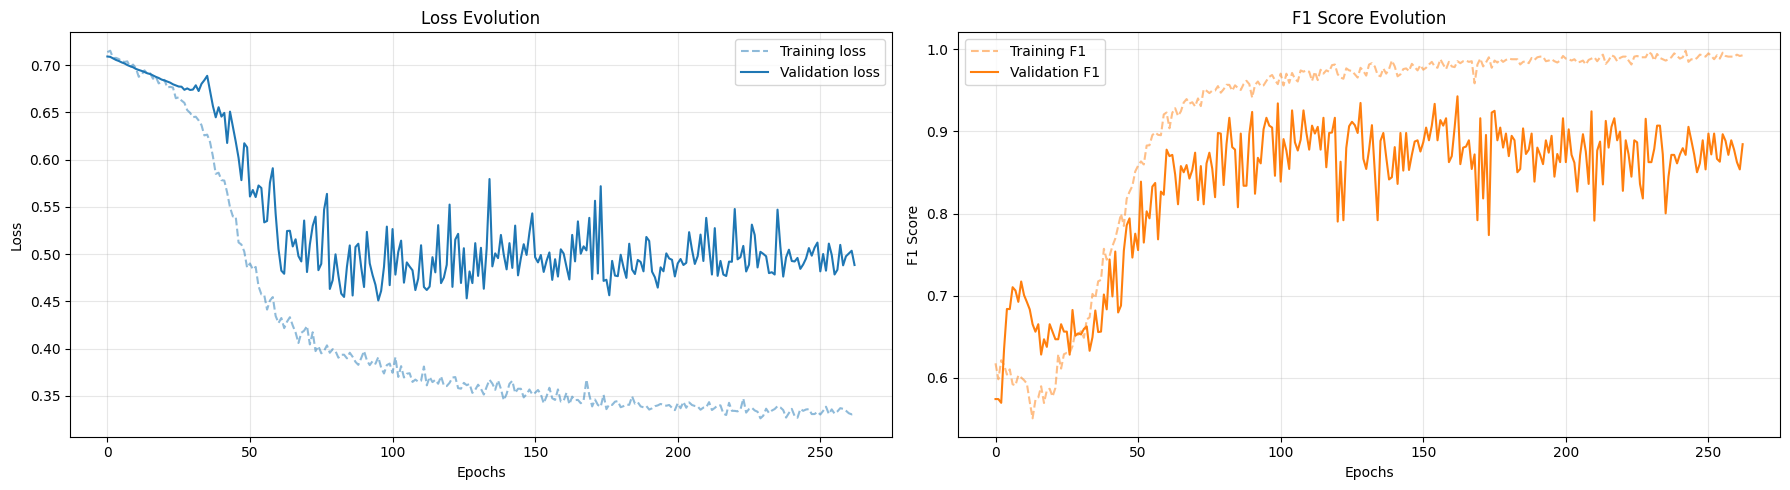

In [36]:

# @title Plot Hitory
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# --- Loss ---
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.5, color='#1f77b4', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=1.0, color='#1f77b4')
ax1.set_title('Loss Evolution')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# --- F1 Score ---
ax2.plot(training_history['train_f1'], label='Training F1', alpha=0.5, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation F1', alpha=1.0, color='#ff7f0e')
ax2.set_title('F1 Score Evolution')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Inference


In [37]:
torch.cuda.empty_cache()
gc.collect()

# empty istance to load best weights
best_model = ThreeBranchSimpleCNN(
    n_tabular_features=n_tabular_features,
    n_classes=n_classes,
    dropout=DROPOUT_RATE
).to(device)

weights_path = f"{model_dir}/{experiment_name}.pt"
best_model.load_state_dict(torch.load(weights_path, map_location=device))

best_model.eval()

print("Best model loaded successfully.")
#print(best_model)                      # print the best model values

Best model loaded successfully.


In [38]:
test_preds = []
test_targets_segments = []

device_type = 'cuda' if device.type == 'cuda' else 'cpu'

with torch.no_grad():
    for limb_in, prec_in, tab_in, targets in test_loader:

        limb_in = limb_in.to(device)
        prec_in = prec_in.to(device)
        tab_in = tab_in.to(device)

        # autocast
        with torch.amp.autocast(device_type=device_type, enabled=(device.type=='cuda')):
            logits = best_model(limb_in, prec_in, tab_in)

        preds = torch.argmax(logits, dim=1).cpu().numpy()

        test_preds.append(preds)
        test_targets_segments.append(targets.numpy())

test_preds = np.concatenate(test_preds)
test_targets_segments = np.concatenate(test_targets_segments)

print(f"Total Segments Predicted: {test_preds.shape[0]}")

Total Segments Predicted: 106


In [39]:
#@title Aggregation Logic to get one prediction

signal_length_original = 5000
segments_per_patient = math.ceil(signal_length_original / WINDOW_SIZE)

print(f"Aggregating predictions: {segments_per_patient} segments per patient. \n")

final_patient_preds = []
true_patient_labels = []

num_patients = len(test_preds) // segments_per_patient

for i in range(num_patients):
    start_idx = i * segments_per_patient
    end_idx = start_idx + segments_per_patient

    # Majority Voting
    patient_votes = test_preds[start_idx : end_idx]
    vote_counts = Counter(patient_votes)
    most_common_label = vote_counts.most_common(1)[0][0]
    final_patient_preds.append(most_common_label)

    # ground truth
    patient_targets = test_targets_segments[start_idx : end_idx]
    true_label = patient_targets[0]
    true_patient_labels.append(true_label)

final_patient_preds = np.array(final_patient_preds)
true_patient_labels = np.array(true_patient_labels)

# Mapping
if 'test_ids' in globals() and len(test_ids) >= len(final_patient_preds):
    current_ids = test_ids[:len(final_patient_preds)]
else:
    current_ids = np.arange(len(final_patient_preds))

label_mapping = {
    0: "Class_0",
    1: "Class_1"
}

pred_readable = [label_mapping.get(x, x) for x in final_patient_preds]

out_df = pd.DataFrame({
    'ECG_patient_id': current_ids,
    'True_Label_Code': true_patient_labels,
    'Pred_Label_Code': final_patient_preds,
    'Is_Correct': final_patient_preds == true_patient_labels
})

# save results
csv_path = f'{model_dir}/{experiment_name}_patient_results.csv'
out_df.to_csv(csv_path, index=False)

print(out_df.head(10))

# final report
print("\n\n\n" + "="*30)
print("         FINAL REPORT")
print("="*30)

unique_labels = np.unique(np.concatenate((true_patient_labels, final_patient_preds)))
target_names = [label_mapping[l] for l in unique_labels]

print(classification_report(true_patient_labels, final_patient_preds, target_names=target_names))

# confusion matrix
cm = confusion_matrix(true_patient_labels, final_patient_preds)
print("\nConfusion Matrix:")
print(cm)

acc = np.mean(final_patient_preds == true_patient_labels)
print(f"\nGlobal Accuracy: {acc*100:.2f}% \n\n\n\n")

Aggregating predictions: 2 segments per patient. 

   ECG_patient_id  True_Label_Code  Pred_Label_Code  Is_Correct
0             413                0                0        True
1             529                0                0        True
2             549                1                0       False
3             269                0                0        True
4             484                1                1        True
5             512                0                0        True
6             426                0                0        True
7             378                0                0        True
8             495                0                0        True
9             338                0                0        True



         FINAL REPORT
              precision    recall  f1-score   support

     Class_0       0.94      0.94      0.94        17
     Class_1       0.97      0.97      0.97        36

    accuracy                           0.96        53
  

In [40]:
# @title Resample to validate the model --> resample X time, then average

# reload result if not in memory, otherwise use the two below
# df_results = pd.read_csv(f'{model_dir}/{experiment_name}_patient_results.csv')
# y_true = df_results['True_Label_Code'].values
# y_pred = df_results['Pred_Label_Code'].values

y_true = true_patient_labels
y_pred = final_patient_preds

N_ITERATIONS = 30000    # how many time do you want to reroll the results
n_size = len(y_true)
stats_f1 = list()
stats_acc = list()

print(f"Calculating stability on {n_size} patients using Bootstrapping ({N_ITERATIONS} iterations)...")

for i in range(N_ITERATIONS):
    # resample index
    indices = resample(range(n_size), n_samples=n_size)

    resampled_true = np.array([y_true[i] for i in indices])
    resampled_pred = np.array([y_pred[i] for i in indices])


    score_f1 = f1_score(resampled_true, resampled_pred, average='weighted')
    score_acc = accuracy_score(resampled_true, resampled_pred)

    stats_f1.append(score_f1)
    stats_acc.append(score_acc)

# --- result ---
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_f1 = max(0.0, np.percentile(stats_f1, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper_f1 = min(1.0, np.percentile(stats_f1, p))

print("\n" + "="*40)
print(f" MODEL STABILITY (95% Confidence Interval)")
print("="*40)
print(f"Mean F1-Score: {np.mean(stats_f1):.4f}")
print(f"F1 Interval:  [{lower_f1:.4f} - {upper_f1:.4f}]")
print("-" * 40)

width = upper_f1 - lower_f1
if width < 0.10:
    print("✅ ASSESSMENT: The model is VERY STABLE")
elif width < 0.20:
    print("⚠️ ASSESSMENT: The model is FAIRLY STABLE")
else:
    print("❌ ASSESSMENT: The model is UNSTABLE")


Calculating stability on 53 patients using Bootstrapping (30000 iterations)...

 MODEL STABILITY (95% Confidence Interval)
Mean F1-Score: 0.9623
F1 Interval:  [0.9048 - 1.0000]
----------------------------------------
✅ ASSESSMENT: The model is VERY STABLE


#FINE ---> fare k fold sicuramnete / sistemare il preprocessing da controllare, non so se è corretto e va bene

----------------------------------------------------------------------------------------------------------------------------------------------------------------